# Part 1: Reconstruction of a positive wavefunction

## Getting Started

The following imports are needed to run this tutorial:

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from qucumber.quantum_reconstruction import QuantumReconstruction
from qucumber.positive_wavefunction import PositiveWavefunction

from qucumber.callbacks import MetricEvaluator

import qucumber.utils.training_statistics as ts
import qucumber.utils.data as data

import quantum_ising_chain
from quantum_ising_chain import TFIMChainEnergy, TFIMChainMagnetization
                                # for calculating observables after training. More later...

The quantum wavefunction reconstruction occurs in the *QuantumReconstruction*. A *QuantumReconstruction* object is initialized with a neural network state (in this case, a *PositiveWavefunction* object based on our system of interest - a transverse-field Ising model).

*callbacks* contains functions that allow the user to evaluate the quality of the training (i.e. based on the fidelity or KL divergence). *training_statistics* contains the utilities in order to calculate these training evaluators.

*data* contains functions that handle loading the training data.

*quantum_ising_chain* is not a part of QuCumber; it comprises of classes and functions that will calculate the energy and magnetization of a transverse-field Ising model (TFIM). *quantum_ising_chain* inherits properties from the *Observables* class (part of QuCumber - see observables.py). We encourage users to follow a similar structure to *quantum_ising_chain* when calculating observables for other systems (i.e. not a TFIM).

## Training

Let's beging with training the RBM on a positive wavefunction. We consider the quantum Ising model with the Hamiltonian $H=-J\sum_{\langle i j \rangle} S^z_i S^z_j - h \sum_i S^x_i$
at its quantum critical point $h/J=1$.  The training data has been generated and is contained in the file *tfim1d_N10_train_samples.txt*.  It contains 10,000 measurements of the $S^z$ states of 10 qubits, represented as zeros or ones.

To evaluate how well the RBM is training, we compute the fidelity, $|\langle \psi|\psi_{\rm RBM} \rangle|^2$, between the true wavefunction of the system and the wavefunction the RBM reconstructs. First, we need to load our training data and the true wavefunction of this system.

In [2]:
train_samples_path = 'tfim1d_train_samples.txt'
psi_path           = 'tfim1d_psi.txt'

train_samples,target_psi = data.load_data(train_samples_path,psi_path)

The following arguments are required to construct a **PositiveWavefunction** neural network state:

1. **The number of visible units**. This is 10 for the case of our dataset.
2. **The number of hidden units in the hidden layer of the RBM**. This number is set to the number of visible units by default (10 in the case of our dataset).

One may also choose to run this tutorial on a GPU by adding in "gpu = True" as an argument to **PositiveWavefunction**. 

In [3]:
nv = train_samples.shape[-1]
nh = nv

nn_state = PositiveWavefunction(num_visible=nv,num_hidden=nh,gpu=False)

Now we can specify the parameters of the training process:

1. **epochs**: the number of epochs, i.e. training cycles that will be performed.
2. **batch_size**: the number of data points used in the positive phase of the gradient.
3. **num_chains**: the number of data points used in the negative phase of the gradient. Keeping this larger than the *batch_size* is preferred.
4. **CD**: the number of contrastive divergence steps.
5. **lr**: the learning rate.
6. **log_every**: how often you would like the program to update you during the training; say we choose 50 - that is, every 50 epochs the program will print out the fidelity. This parameter is required in the *MetricEvaluator*.

In [4]:
epochs     = 16000
batch_size = 100
num_chains = 200
CD         = 10
lr         = 0.001
log_every  = 1000

Once we initialize the parameters of the **PositiveWavefunction** and the **MetricEvaluator**, we can begin training. Our **QuantumReconstruction** object, *qr* (see below), contains a function called *fit* that executes the training process.

In [5]:
nn_state.space = nn_state.generate_hilbert_space(nv) # generate the entire visible space of the system.
callbacks = [MetricEvaluator(log_every,{'Fidelity':ts.fidelity,'KL':ts.KL},target_psi=target_psi,verbose=True)]
# The "verbose=True" argument will print the parameters in { } as a function of the training process.
qr = QuantumReconstruction(nn_state)

In [6]:
nn_state.initialize_parameters() # randomize the network parameters.
qr.fit(train_samples, epochs, batch_size, num_chains, CD, lr, progbar=False, callbacks=callbacks)

Epoch: 1000	Fidelity = 0.929332	KL = 0.141219
Epoch: 2000	Fidelity = 0.972524	KL = 0.054816
Epoch: 3000	Fidelity = 0.984452	KL = 0.031128
Epoch: 4000	Fidelity = 0.988511	KL = 0.023271
Epoch: 5000	Fidelity = 0.990440	KL = 0.019454
Epoch: 6000	Fidelity = 0.991862	KL = 0.016531
Epoch: 7000	Fidelity = 0.993202	KL = 0.013750
Epoch: 8000	Fidelity = 0.994288	KL = 0.011509
Epoch: 9000	Fidelity = 0.995138	KL = 0.009778
Epoch: 10000	Fidelity = 0.995713	KL = 0.008605
Epoch: 11000	Fidelity = 0.996187	KL = 0.007668
Epoch: 12000	Fidelity = 0.996337	KL = 0.007348
Epoch: 13000	Fidelity = 0.996585	KL = 0.006868
Epoch: 14000	Fidelity = 0.996795	KL = 0.006447
Epoch: 15000	Fidelity = 0.996927	KL = 0.006178
Epoch: 16000	Fidelity = 0.996975	KL = 0.006089

Elapsed time = 3246.90


## After Training 

After training the RBM, the *fit* function will have stored the trained weights and biases. Now, we can generate samples from the trained RBM and calculate physical observables.

We have created an example python file called *quantum_ising_chain.py* that calculates the energy and magnetization of a TFIM.

*quantum_ising_chain* comprises of two classes: one to calculate the energy of a TFIM (**TFIMChainEnergy**) and one to calculate the magnetization of a TFIM (**TFIMChainMagnetization**). The following arguments are required to instatiate those objects.

1. **h**: This is the *h/J* value of the TFIM (1 in the case of our dataset). This is only needed in **TFIMChainEnergy**.
2. **n_samples**: The number of samples to be generated from the trained RBM. These samples will be used to calculate the observables.

In [7]:
h         = 1
n_samples = 10000

tfim_energy = TFIMChainEnergy(h, n_samples)
tfim_sZ     = TFIMChainMagnetization(n_samples)

As stated previously, the **TFIMChainEnergy** and **TFIMChainMagnetization** classes inherit properties from **Observables**. To go ahead and calculate the energy and magnetization along with their respective standard errors, we call the *statistics* function in **Observables**, which requires the neural network state (in this case, **PositiveWavefunction**) and the number of samples that are to be generated. 

In [8]:
energy_stats = tfim_energy.statistics(nn_state, n_samples)
sZ_stats     = tfim_sZ.statistics(nn_state, n_samples)

print('Mean energy: ',energy_stats['mean'],' +/- ',energy_stats['std_error'])
print('Mean magnetization: ',sZ_stats['mean'],' +/- ',sZ_stats['std_error'])

Mean energy:  -1.2364295123948248  +/-  0.0003432660437618456
Mean magnetization:  0.5540800000000004  +/-  0.003109421523406063


The exact value for the energy is -1.2381, and for the magnetization is 0.5610. To see the how quickly the energy and magnetization converge as a function of the sampling step, *n_eq*, the code below will do the trick.

Text(0,0.5,'Magnetization')

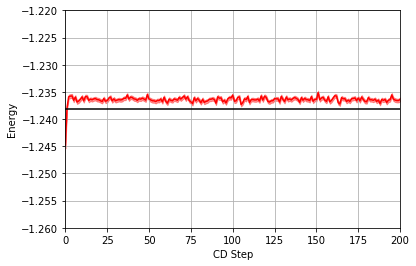

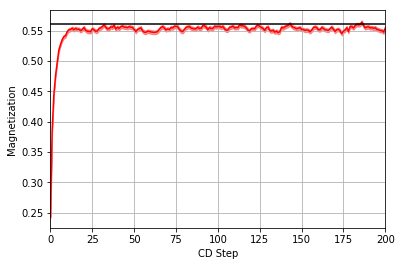

In [9]:
n_eq = 200
dict_observables = quantum_ising_chain.Convergence(nn_state, tfim_energy, tfim_sZ, n_samples, n_eq)

energy     = dict_observables['energy']['energies']
err_energy = dict_observables['energy']['error']

sZ     = dict_observables['sigmaZ']['sZ']
err_sZ = dict_observables['sigmaZ']['error']

step = list(range(n_eq+1))

plt.figure(1)
ax1 = plt.axes()
ax1.plot(step, energy, color='red')
ax1.axhline(-1.2381, color='black')
ax1.fill_between(step, energy-err_energy, energy+err_energy, color='red', alpha=0.4) 
ax1.grid()
ax1.set_xlim(0,n_eq)
ax1.set_ylim(-1.26,-1.22)
ax1.set_xlabel('CD Step')
ax1.set_ylabel('Energy')

plt.figure(2)
ax2 = plt.axes()
ax2.plot(step, sZ, color='red')
ax2.axhline(0.5610, color='black')
ax2.fill_between(step, sZ-err_sZ, sZ+err_sZ, color='red', alpha=0.4) 
ax2.grid()
ax2.set_xlim(0,n_eq)
ax2.set_xlabel('CD Step')
ax2.set_ylabel('Magnetization')

You can see a brief transient period in each observable, before the state of the machine "warms up" to equilibrium.  After that, the values fluctuate around the mean.